<a href="https://colab.research.google.com/github/acse-moj20/msc-irp/blob/dev/PredGAN/Compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dev Code (PredGAN) For Fluid Problem**

Setup and package import

In [1]:
%matplotlib inline
import sys
import os
import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd


mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Processing Power and Available Memory

GPU Specs

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('GPU info not found.')
else:
  print(gpu_info)

print('Num of available GPUs: ', len(tf.config.list_physical_devices('GPU')))

Wed Jun 23 09:46:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Memory Allocation

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM



## Data Preparation & Transformation

What we know so far:


*   Dataset represents the parameter values of u, v and p for 100 separate examples of the high fidelity solution.
*   Each example is computed over 50 timesteps and a on a 256-by-256 grid.

*   Vorticity over the vector field is obatined by computing the curl of u (x-component velocity vector) and v (y-component velocity vector)






In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


###**Raw data transformation**

####**Get Data from Drive**

To be run only once

In [18]:
# data_dir = 'drive/MyDrive/MSC_IRP/data/vortex_100.npy'

# # Load x and y velocity components.
# data_file = np.load(data_dir)

# print('Size of dataset:         ', data_file.shape)
# print('Number of data samples:  ', len(data_file))
# print('Size of each sample:     ', data_file[0].shape)
# print('Number of time steps:    ', len(data_file[0]))

In [19]:

# # Data transformation - computing vorticity from vector field.
# # vorticity is the curl of the velocity vector field (raw dataset).

# def curl(u,v):
#   """ 
#   Function to calculate the curl of a 2-dimensional vector field.
#   Parameters:
#   -----------
#     u : 2d array of size n*m
#       vector component in the x direction.

#     v : 2d array of size n*m
#       vector component in the y direction
#   Output:
#   -------
#     curl : 2d array of size n*m
#       curl of vector field [i.e. (dv/dx)i - (du/dy)j]
#   """
#   curl = np.gradient(v)[0] - np.gradient(u)[1]
#   return curl

# def plot_vort(data, times):
#   fig, ax = plt.subplots(1, len(times), figsize=[20,10])
#   for i, step in enumerate(times):
#     u = data[step][:, :, 0] # x-velocity
#     v = data[step][:, :, 1] # y-velocity
#     im = ax[i].imshow(curl(u, v), cmap='RdBu')
#     ax[i].set_xlabel('X'), ax[i].set_ylabel('y')
#     ax[i].set_xticklabels([]), ax[i].set_yticklabels([])
#     ax[i].set_xticks([]), ax[i].set_yticks([])
#     cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
#     ax.flatten()[i].set_title('t = {}'.format(step), y=1.05, 
#                             fontsize=16, fontweight="bold")
#   plt.show()

# times = [0, 10, 20, 49]
# data = data_file[58]
# plot_vort(data, times)

####**Save Transformed Data to Drive**

To be run only once

In [7]:
# Compute and save vorticity for easier data loading

# vorticity = np.zeros((100, 50, 256, 256))
# for i in range(len(data_file)):
#  for j in range(len(data_file[0])):
#    vorticity[i][j] = curl(data_file[i][j][:, :, 0], data_file[i][j][:, :, 1])
# save_dir = 'drive/MyDrive/MSC_IRP/data/calc_vortex_100.npy'
# np.save(save_dir, vorticity)

###**Dataset visualization**

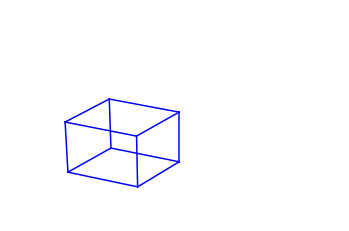

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure()
ax = fig.gca(projection='3d')


# draw cube
r = [-1, 0]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="b")
r = [1, 1]
for s, e in combinations(np.array(list(product(r, r, r))), 2):
    if np.sum(np.abs(s-e)) == r[1]-r[0]:
        ax.plot3D(*zip(s, e), color="b")
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_axis_off()
plt.show()

###**Data Preparation**

The training dataset will consist of 100 samples of a high-fidelity numerical simulation each with 50 evenly sampled snapshots (in time). Each simulation represents velocity (in x and y directions) and pressure for the turbulent flow model over a region of grid size 256x256. These values can be used to generate a vorticity field for the model. Thus, there is a total number of 256 * 256 = 65,536 variables per time step and a total of 50 * 100 = 5,000 samples. Dimensionality reduction of this high dimensional space is then performed using Principal Component Analysis (PCA) in order to work with a relatively low dimension space.

In [6]:
# Load vortex data as traing data.
X_train3d = np.load('drive/MyDrive/MSC_IRP/data/calc_vortex_100.npy')

In [10]:
def plot_vortex(data, times):
  fig, ax = plt.subplots(1, len(times), figsize=[20,10])
  
  for i, step in enumerate(times):
    im = ax[i].imshow(data[step], cmap='RdBu')
    ax[i].set_xlabel('X'), ax[i].set_ylabel('y')
    ax[i].set_xticklabels([]), ax[i].set_yticklabels([])
    ax[i].set_xticks([]), ax[i].set_yticks([])
    cbar = plt.colorbar(im, ax=ax.flatten()[i], shrink=0.24, pad=0.05, panchor=(0.0, 0.0))
    ax.flatten()[i].set_title('t = {}'.format(step), y=1.05, 
                            fontsize=16, fontweight="bold")
  plt.show()

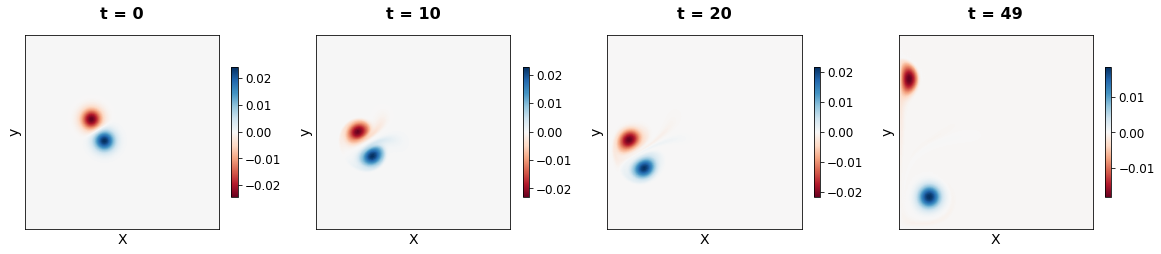

In [11]:
times = [0, 10, 20, 49]
plot_vortex(X_train3d[58], times)

In [9]:
nx = len(X_train3d[0][0])
X_train3d.shape

(100, 50, 256, 256)

In [ ]:
from sklearn.preprocessing import StandardScaler
stdscale = StandardScaler()

**Dimensionality reduction - PCA**

In [10]:
X_train1d = X_train3d.reshape((-1, nx*nx))
X_train1d.shape

(5000, 65536)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(X_train1d.shape[0])
X_train_pca = pca.fit_transform(X_train1d)

In [12]:
X_recovered_1d = pca.inverse_transform(X_train_pca)
np.allclose(X_recovered_1d, X_train1d)

True

In [14]:
p = 0.999
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum_eig >= p) + 1 # returns the indices of the maximum values along an axis.
d

292

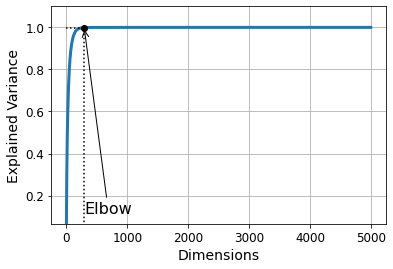

In [15]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [16]:
p = 0.999
cumsum_sv = np.cumsum(pca.singular_values_/sum(pca.singular_values_))
d = np.argmax(cumsum_sv >= p) + 1
d

3484

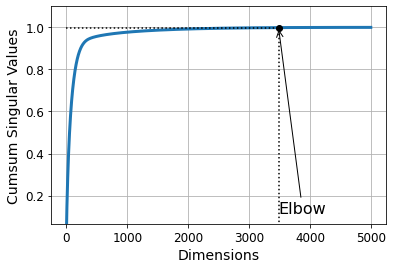

In [17]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_sv, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Singular Values")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

**Dimensionality reduction - 2D PCA**

In [14]:
X_train2d = X_train3d.reshape((-1, nx, nx))

In [15]:
X_train2d.shape

(5000, 256, 256)